## DIY Neural Network Layer Visualization


In [1]:
import numpy as np
import cv2
import sys
import tensorflow as tf

import threading
import time
import random

#sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/home/watstock/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Model Specification
Here we load the [ssd_inception_v2_coco_2017_11_17](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

In [2]:
FROZEN_GRAPH_NAME = 'frozen_inference_graph.pb'

PATH_TO_CKPT = 'model/' + FROZEN_GRAPH_NAME
PATH_TO_LABELS = 'model/' + 'mscoco_label_map.pbtxt'

NUM_CLASSES = 90
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480

### SETUP OPENCV FRAMES
Here we use seperate threads for getting the webcam output and doing the visualizations.

In [3]:
class OutputFrame:
    def __init__(self):
        self.frame = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,3))
        self.boxes = ()
        self.frame_disp = np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,3))
        self.visualization_data = ()

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

class WebcamThread(threading.Thread):
   def __init__(self, name):
      threading.Thread.__init__(self)
      self.name = name
   def run(self):
      print("Starting " + self.name)
      get_frame(self.name)
      print("Exiting " + self.name)

def get_frame(threadName):
    while not done:
        _, frame = cap.read()
        output_frame.frame = frame

class PredictorThread(threading.Thread):
   def __init__(self, name, detection_graph,sess,output_frame):
        threading.Thread.__init__(self)
        self.name = name
        self.detection_graph = detection_graph
        self.sess = sess
        self.output_frame = output_frame
    
   def run(self):
      print("Starting " + self.name)
      predict(self.name,self.detection_graph,self.sess,self.output_frame)
      print("Exiting " + self.name)

def predict(threadName,detection_graph,sess,output_frame):
    while not done:
        _, image_np = cap.read()
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        # (1,75,75,64)
        layer_1 = detection_graph.get_tensor_by_name(
          'FeatureExtractor/InceptionV2/InceptionV2/Conv2d_2b_1x1/Relu6:0')
        # (1,38,38,128)
        layer_2 = detection_graph.get_tensor_by_name(
          'FeatureExtractor/InceptionV2/InceptionV2/Mixed_4a/Branch_0/Conv2d_0a_1x1/Relu6:0')

        # (1, 19, 19, 192)
        layer_3 = detection_graph.get_tensor_by_name(
          'FeatureExtractor/InceptionV2/InceptionV2/Mixed_4c/Branch_0/Conv2d_0a_1x1/Relu6:0')

        # (1, 10, 10 , 128)
        layer_4 = detection_graph.get_tensor_by_name(
          'FeatureExtractor/InceptionV2/InceptionV2/Mixed_5c/Branch_3/Conv2d_0b_1x1/Relu6:0')
        # Actual detection.
        with sess.as_default(), detection_graph.as_default():
            [layer_1_out, layer_2_out, layer_3_out, layer_4_out,
             temp_box, temp_score, temp_class,num_detections] = sess.run(
              [layer_1, layer_2,layer_3,layer_4,
                  boxes, scores, classes, num_detections],
    feed_dict={image_tensor: image_np_expanded})
            output_frame.boxes = [temp_box, temp_score, temp_class,num_detections]
            output_frame.visualization_data = [layer_1_out, layer_2_out, layer_3_out, layer_4_out]

In [4]:
def get_graph(PATH_TO_CKPT):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')   
            return detection_graph

### VISUALIZATION HELPER FUNCTION
**This function displays a cascade of the layers so it is easy to visualize.**

In [5]:
def display_activations(layers,num_features=6,padding=5,filter_size=(-1,-1)):
    # We only want to pick random layers the first time the program runs.
    random.seed(9001) 

    # If the filter size has not been specified, we use the first layer's size to calculate it.
    if filter_size[0] == -1 or filter_size[1] == -1:
        height = layers[0].shape[1]
        width = height
    else:
        width = filter_size[0]
        height = filter_size[1]

    # Total size of the image with all filters being shown.
    total_height = (height + padding)*(num_features + 0) # The width includes the padding
    total_width = (width + padding)*len(layers)

    # Output matrix initialization.
    nn_visualize_np = np.zeros(shape=[total_width,total_height])
    prev_m_height = 0
    for j in range(len(layers)): # Represents each layer
        for feat in range(num_features): # Represents the features for a layer
            num_feats = layers[j].shape[3] - 1
            this_feat = random.randint(0,num_feats)
            # Extract the relevant matrix. Here we get the 'i^th' feature.
            layer = np.squeeze(layers[j][:,:,:,this_feat])
            # Resize the layer
            layer = cv2.resize(layer, dsize=(width, height), interpolation=cv2.INTER_CUBIC)

            # Calculate the begining and end offsets for width
            b_offset_w = feat*(width + padding)
            e_offset_w = b_offset_w + width

            b_offset_h = (prev_m_height + padding)
            e_offset_h = b_offset_h + height 

            # Place them in the visualization grid
            nn_visualize_np[b_offset_h:e_offset_h, b_offset_w:e_offset_w] = layer
        prev_m_height+= height
    out_value = nn_visualize_np / float(nn_visualize_np.max())
        
    return out_value

## LOAD THE GRAPHS

In [6]:
graph = get_graph(PATH_TO_CKPT)
sess = tf.Session(graph=graph)

In [8]:
done = False
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc('a', 'v', 'c', '1') # note the lower case
cap.set(3, IMAGE_WIDTH)
cap.set(4, IMAGE_HEIGHT)
# Load the graphs.

output_frame = OutputFrame()

webcam_thread = WebcamThread("Webcam Thread")
predictor_thread = PredictorThread("Predictor Thread",graph,sess,output_frame)
webcam_thread.start()

Starting Webcam Thread


### EXECUTE THE PREDICTOR THREAD
**NOTE: Only run this once the webcam thread has initialized**

In [9]:
# Execute this only after the webcam thread has started.
predictor_thread.start()

Starting Predictor Thread


### Single Frame Visualization
**We test the output on the current frame obtained from the webcam.**

In [20]:
# Import the Matplot library
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
layers = [output_frame.visualization_data[0],
         output_frame.visualization_data[0],
         output_frame.visualization_data[2],
         output_frame.visualization_data[2]]
act_map = display_activations(layers,num_filters=6)
updated_act_map = act_map

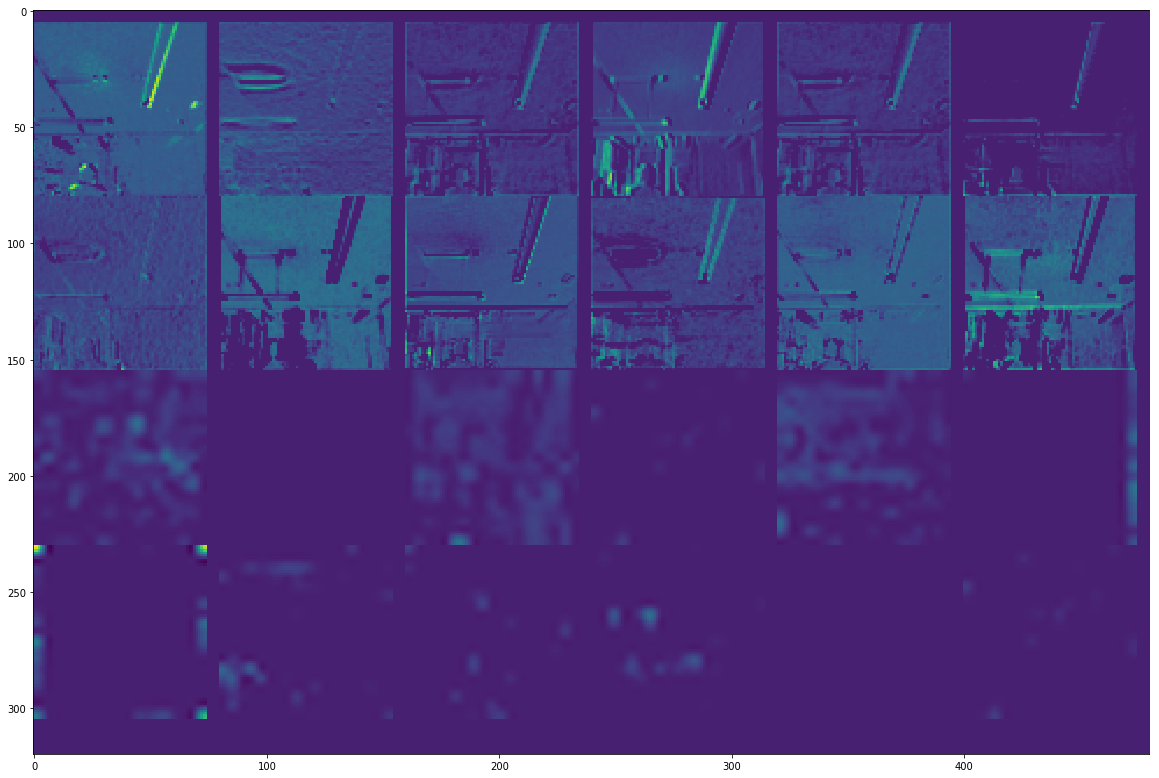

In [45]:
plt.figure(figsize=(20,20)) # Make the Figure Larger
plt.imshow(updated_act_map)

### RUN ON WEBCAM INPUT
**If the above code works, then we can now begin to run the visualization on live video input. To stop at any time, hit the 'q' key on the OpenCV video frame.**

In [ ]:
i = 0
while True:
    if i == 0 or i % 500:
        layers = [output_frame.visualization_data[0],
                 output_frame.visualization_data[0],
                 output_frame.visualization_data[2],
                 output_frame.visualization_data[2]]
        act_map = display_activations(layers,[6, 6, 6, 6])
        updated_act_map = act_map

    if i > 5000:
        i = 0

    cv2.imshow('visualization',cv2.resize(updated_act_map,(0,0),fx=3,fy=3))


    if cv2.waitKey(1) & 0xFF == ord('q'):
        done = True
        break
    i +=1